In [1]:
# ! pip uninstall EfficientSurfaceCodeSim
# ! pip3 install git+https://github.com/JiakaiW/EfficientSurfaceCodeSim

In [2]:
from EfficientSurfaceCodeSim import MCSampleDecodeJob
import uuid
import itertools
import pickle
import zipfile
import os
import math
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
import json
import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, TwoSlopeNorm

In [3]:
# d_to_shots = {3: int(1e5), # 5,000s, 83min
#               5:int(2e4), # 10,500s, 175 min
#               7:int(1e4), # 5,500 s, 91 min
#               9: int(1e4), # 11,000 s, 180 min
#               11: int(1e4) # 20700 s, 360 min
#               }# =>900 min per parameter set

distance_to_sec_per_shot = {
    3:0.1,
    5:0.2,
    7:0.5,
    9:1,
    11:2
}

num combinations 441


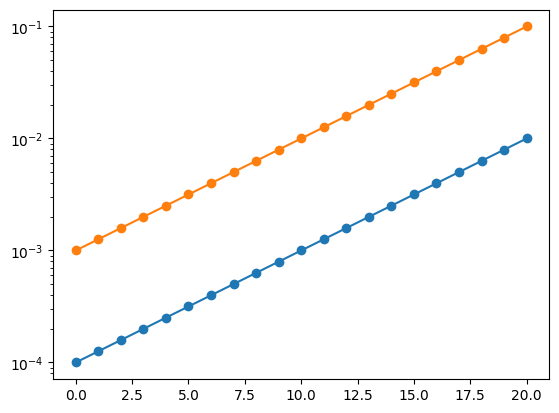

In [4]:
p_p_array = 10 ** np.linspace(-4,-2,21)
p_e_array = 10 ** np.linspace(-3,-1,21)

# print(f"p_p_array: {p_p_array}")
# print(f"p_e_array: {p_e_array}")
plt.plot(p_p_array,marker = 'o')
plt.plot(p_e_array,marker = 'o')
plt.yscale('log')

p_e_list = list(p_e_array)
p_p_list = list(p_p_array)

combinations = list(itertools.product(p_e_list,
                                      p_p_list))
print(f"num combinations {len(combinations)}")

In [98]:
# Variables needed throughout this work
X, Y = np.meshgrid(p_p_list, p_e_list)
int_x_list = np.arange(len(p_p_list))
int_y_list = np.arange(len(p_e_list))
int_X, int_Y = np.meshgrid(int_x_list, int_y_list)
X_eff = (X/0.01)**1
Y_eff = (Y/0.05)**2

p_tot_effective =  Y_eff + X_eff 
erasure_effective_fraction = Y_eff / p_tot_effective

# estimate logical error rate
d_arr = np.arange(0,300)
p_log_est = np.zeros(shape=(*d_arr.shape, *p_tot_effective.shape))
for i,d in enumerate(d_arr):
    p_log_est[i] = p_tot_effective**((d+1)/2)

# estimate how many shots we need to get 100 error
p_shots_needed_for_100_error = np.zeros_like(p_log_est)
for i,d in enumerate(d_arr):
    p_shots_needed_for_100_error[i] =100/p_log_est[i]

cbar_pad = 0.3
cbar_shrink = 0.7

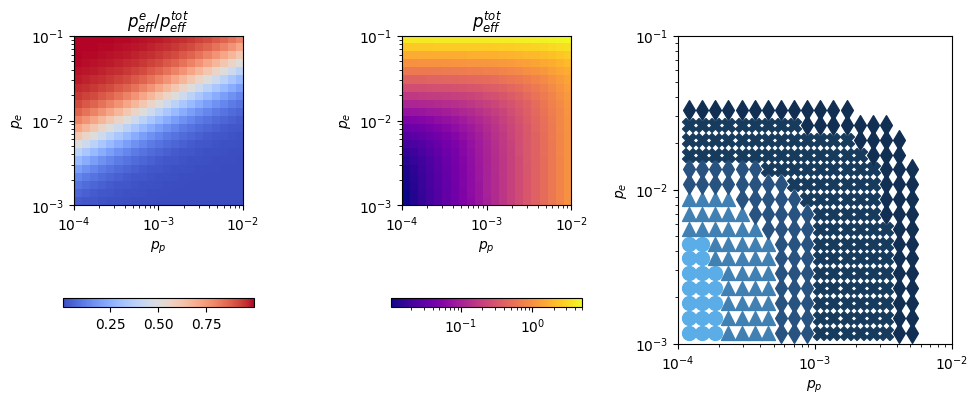

In [99]:
def format_ax(ax):
    ax.set_xticks(np.arange(len(p_p_list)))
    ax.set_yticks(np.arange(len(p_e_list)))
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    pos = ax.get_position()
    ax_twin = fig.add_axes(pos, frameon=False)
    ax_twin.set_xlim(1e-4, 1e-2)
    ax_twin.set_ylim(1e-3, 1e-1)
    ax_twin.set_xscale('log')
    ax_twin.set_yscale('log')
    ax_twin.set_xlabel(r'$p_p$')
    ax_twin.set_ylabel(r'$p_e$')

fig,axes = plt.subplots(1,3,figsize=(12,4))

ax = axes[0]
data = erasure_effective_fraction
norm = TwoSlopeNorm(vmin=data.min(), vcenter=0.5, vmax=data.max())
cax = ax.imshow(data, origin='lower', cmap='coolwarm', norm=norm)
fig.colorbar(cax, ax=ax,orientation='horizontal',pad=cbar_pad, shrink=cbar_shrink)
format_ax(ax)
ax.set_title(r'$p^e_{eff} / p^{tot}_{eff}$')


ax = axes[1]
data = p_tot_effective
cax = ax.imshow(data, origin='lower', cmap='plasma', norm=LogNorm())
fig.colorbar(cax, ax=ax,orientation='horizontal',pad=cbar_pad, shrink=cbar_shrink)
format_ax(ax)
ax.set_title(r'$ p^{tot}_{eff}$')

ax = axes[2]
level = 1e-12
drawn_mask = np.zeros_like(p_tot_effective, dtype=bool)
for d, color,marker in zip( [13,17, 23, 49, 100],
                    [(0.353, 0.678, 0.901),
                     (0.255, 0.502, 0.701),
                     (0.157, 0.322, 0.502),
                     (0.086, 0.231, 0.365),
                     (0.063, 0.184, 0.325),
                     (0.039, 0.137, 0.286)],
                    ['o','^',"d","X",'d']):
    current_mask = np.array(p_log_est[d] <= level, dtype=bool) & ~drawn_mask
    drawn_mask = drawn_mask | current_mask
    ax.scatter(int_X[current_mask], int_Y[current_mask], marker=marker, color=color, s=100, label=f'd{d}',alpha=1)
format_ax(ax)

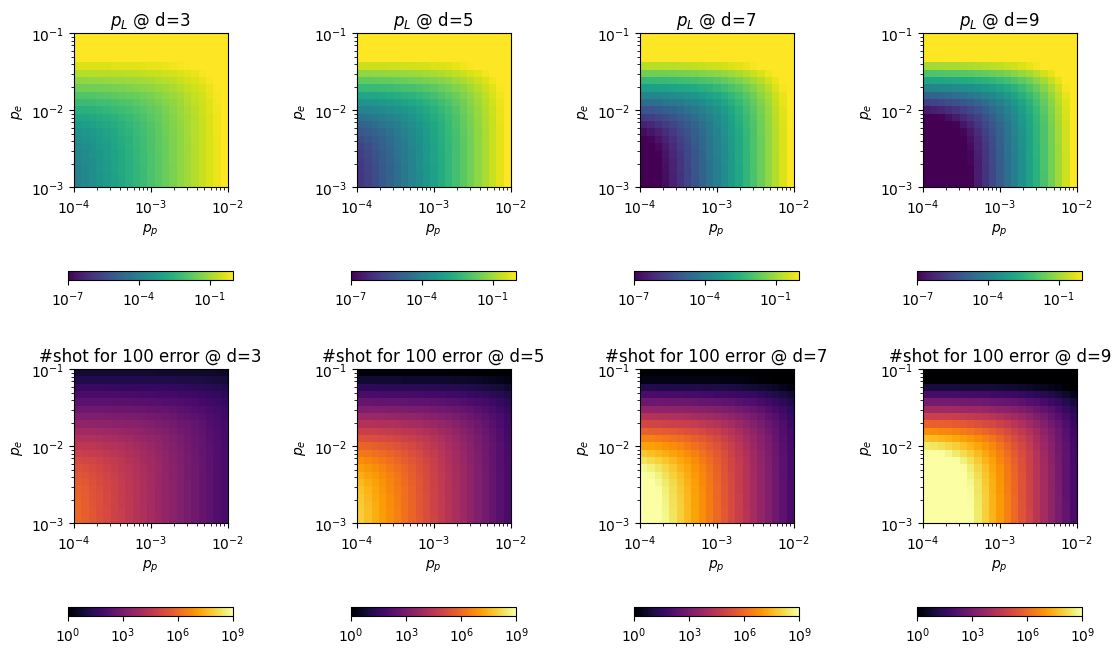

In [114]:
fig,axes = plt.subplots(2,4, figsize=(14,8))
for ax,d in zip(axes[0], [3,5,7,9]):
    cax = ax.imshow(p_log_est[d],norm=LogNorm(vmax=1,vmin=1e-7), origin='lower')
    ax.set_title(rf"$p_L$ @ d={d}")
    fig.colorbar(cax,orientation='horizontal',pad=cbar_pad, shrink=cbar_shrink)
    format_ax(ax)

for ax,d in zip(axes[1], [3,5,7,9]):
    cax = ax.imshow(p_shots_needed_for_100_error[d],norm=LogNorm(vmin=1,vmax=1e9), origin='lower',cmap='inferno')
    ax.set_title(rf"#shot for 100 error @ d={d}")
    fig.colorbar(cax,orientation='horizontal',pad=cbar_pad, shrink=cbar_shrink)
    format_ax(ax)


In [14]:
shots_per_d9_job  = 8000
d_to_num_shots_per_job = {
    9: shots_per_d9_job,
    7: shots_per_d9_job * 2 ,
    5: shots_per_d9_job * 4,
    3: shots_per_d9_job * 8,
}

print(f"time per job: {shots_per_d9_job * distance_to_sec_per_shot[9]} sec, in minutes: {shots_per_d9_job * distance_to_sec_per_shot[9] / 60}")

d_to_num_jobs = {
    9: 33,
    7: 10,
    5: 3,
    3: 1
}

print(f"d3 tot shots {d_to_num_shots_per_job[3] * d_to_num_jobs[3]}")
print(f"d5 tot shots {d_to_num_shots_per_job[5] * d_to_num_jobs[5]}")
print(f"d7 tot shots {d_to_num_shots_per_job[7] * d_to_num_jobs[7]}")
print(f"d9 tot shots {d_to_num_shots_per_job[9] * d_to_num_jobs[9]}")

print(f"tot jobs: {len(combinations) * np.sum([val for key, val in d_to_num_jobs.items()])}")

time per job: 8000 sec, in minutes: 133.33333333333334
d3 tot shots 64000
d5 tot shots 96000
d7 tot shots 160000
d9 tot shots 264000
tot jobs: 20727


In [110]:
counter = 0
jobs_info = []

for (p_e,p_p) in combinations:
    for d in [3,5,7,9]:
        num_jobs = d_to_num_jobs[d]
        num_shots_per_job = d_to_num_shots_per_job[d]
        
        circuit_id=str(uuid.uuid4())
        for _ in range(num_jobs):
            job_id=str(uuid.uuid4())
            job = MCSampleDecodeJob(
                            job_id=job_id,
                            circuit_id=circuit_id,
                            d = d,
                            p_e=p_e,
                            p_p=p_p,
                            shots=num_shots_per_job,
                            )
            with open(f"{counter}.pkl", "wb") as f:
                pickle.dump(job, f)
            counter += 1

            jobs_info.append({
                "job_id": job_id,
                "circuit_id": circuit_id,
                "d": d,
                "p_e": p_e,
                "p_p": p_p,
                "shots": num_shots_per_job,
                "file": f"{counter}.pkl"
            })
print(f"num_jobs: {counter}")

# Save jobs information to a JSON file
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
json_filename = f"jobs_info_{timestamp}.json"
with open(json_filename, "w") as json_file:
    json.dump(jobs_info, json_file, indent=4)

def pack_pkl_files_to_zip(zip_filename="erasure_input.zip"):
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for filename in os.listdir('.'):
            name, ext = os.path.splitext(filename)
            if ext == '.pkl' and name.isdigit():
                zipf.write(filename)
                os.remove(filename)
                
pack_pkl_files_to_zip()

num_jobs: 9870


In [112]:
import os
import json
import pandas as pd

json_list = []
directory = "erasure_decode_result_v2"
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as f:
            json_data = json.load(f)
        json_list.append(json_data)

df = pd.DataFrame(json_list)


In [114]:
# df.drop('job_id', axis=1, inplace=True)
agg_rules = {
    'shots': 'sum',
    'new_circ': 'sum',
    # 'normal': 'sum',
    'p_e': 'first',
    'p_z_shift': 'first',
    'p_p': 'first',
    'p_m': 'first',
}

df_grouped = df.groupby(['circuit_id', 'd']).agg(agg_rules).reset_index()
df_grouped['p_logi_era'] = df_grouped['new_circ'] / df_grouped['shots']
# df_grouped['p_logi_normal'] = df_grouped['normal'] / df_grouped['shots']


,circuit_id,d,shots,new_circ,p_e,p_z_shift,p_p,p_m,p_logi_era
0,00303a1d-e4e2-4eea-b369-df2c7ee44c16,7,160000,15625,0.017053,0.0,0.013257,0.0,0.097656
1,0031a513-89d8-4b60-a35f-5b0cabeb9d13,5,96000,1,0.008397,0.0,0.000063,0.0,0.000010
2,003a9f8f-9ce7-4309-aea8-f95d40cda647,5,96000,3,0.024302,0.0,0.000063,0.0,0.000031
3,01137593-a45e-431c-9490-1cfd1ec247bd,7,160000,0,0.011966,0.0,0.000494,0.0,0.000000
4,0135ccb3-2ce8-472e-a383-8d40428f89b5,3,64000,50,0.008397,0.0,0.000746,0.0,0.000781
5,01375ff1-6ba6-4843-af38-cdae56329696,7,160000,2718,0.002036,0.0,0.008788,0.0,0.016987
6,01419d36-fbec-4764-b764-54942cb9dee3,5,96000,2,0.011966,0.0,0.000144,0.0,0.000021
7,015e5684-264d-49c5-b0f1-9771c60c2dcc,9,264000,0,0.008397,0.0,0.000746,0.0,0.000000
8,01e3e255-2c67-44d0-b7ee-6cd7cfc276a3,3,64000,2126,0.001002,0.0,0.013257,0.0,0.033219
9,0212bcf4-035b-4372-9b05-54faa586fbf0,5,96000,28,0.002901,0.0,0.001697,0.0,0.000292


In [116]:
def compute_binary_confidence_interval(num_positive, n_samples, confidence_level=0.95):
    p_hat = num_positive / n_samples  # Estimated probability
    standard_error = math.sqrt((p_hat * (1 - p_hat)) / n_samples)
    z = 1.96  # For a 95% confidence level
    margin_of_error = z * standard_error
    lower_bound = p_hat - margin_of_error
    upper_bound = p_hat + margin_of_error
    lower_bound = max(0,lower_bound)
    return lower_bound, upper_bound


In [117]:

unsaturated_colors = {
    'red': {
        3: (0.86, 0.371, 0.339),
        5: (0.8, 0.251, 0.231),
        7: (0.71, 0.086, 0.063),
        9: (0.64, 0.051, 0.051),
        11: (0.53, 0.035, 0.035),
        13: (0.43, 0.024, 0.024)
    },
    'blue': {
        3: (0.353, 0.678, 0.901),
        5: (0.255, 0.502, 0.701),
        7: (0.157, 0.322, 0.502),
        9: (0.086, 0.231, 0.365),
        11: (0.063, 0.184, 0.325),
        13: (0.039, 0.137, 0.286)
    },
    'green': {
        3: (0.467, 0.775, 0.459),
        5: (0.376, 0.686, 0.373),
        7: (0.286, 0.596, 0.286),
        9: (0.216, 0.51, 0.216),
        11: (0.169, 0.435, 0.169),
        13: (0.133, 0.365, 0.133)
    },
    'light_purple': {
        3: (0.659, 0.486, 0.756),
        5: (0.557, 0.376, 0.647),
        7: (0.467, 0.278, 0.549),
        9: (0.388, 0.192, 0.459),
        11: (0.318, 0.118, 0.384),
        13: (0.259, 0.059, 0.318)
    }
}


def plot_logi_vs_intrin(p_e,p_m, p_z_shift):
    df = df_grouped
    filtered_df = df.loc[(df['p_e'] == p_e) &
                         (df['p_m'] == p_m) &
                         (df['p_z_shift'] == p_z_shift)]

    group_by_columns = ['d']        

    for _, group in filtered_df.groupby(group_by_columns):
        distance = group.iloc[0]['d']
        x_values = group['p_p']
        y_values = group['p_logi_era']

        x_y_values = zip(x_values, y_values)
        sorted_xy_values = sorted(x_y_values, key=lambda v: v[0])
        sorted_x, sorted_y = zip(*sorted_xy_values)
        color = unsaturated_colors['blue'].get(distance, 'blue')
        plt.plot(sorted_x, sorted_y, color=color, label=f'd_{distance}_conditional_prob_decoding')
        
        # CI
        m = group['new_circ']
        n = group['shots']
        m_n_x_values = zip(m, n,x_values)
        sorted_mn_values = sorted(m_n_x_values, key=lambda v: v[-1])
        sorted_m, sorted_n,sorted_x = zip(*sorted_mn_values)
        num_positive = sorted_m
        n_samples = sorted_n
        lower_bound, upper_bound = zip(*[compute_binary_confidence_interval(num, n) for num, n in zip(num_positive, n_samples)])
        plt.fill_between(sorted_x, lower_bound, upper_bound, color=color, alpha=0.3)

    # Set log scales for both x and y axes
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
    # Set plot labels and legend
    plt.title(f'leakage{p_e},p_z from shift{p_z_shift}')
    plt.xlabel('p_intrin')
    plt.ylabel('Per shot logical error')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()




def make_logi_vs_intrin_widget():
    interactive_plot = interactive(plot_logi_vs_intrin,
                p_e = p_e_list,
                p_m = p_m_list,
                p_z_shift = p_z_shift_list)
    return interactive_plot


make_logi_vs_intrin_widget()

interactive(children=(Dropdown(description='p_e', options=(0.10023744672545448, 0.07033700014339496, 0.0493557…

# Now I have a dataframe that describe p_logi_era as a function of d, p_e, p_p, (and p_m). I want to know if a (p_e, p_p) is above or below the threshold.

In [198]:
import numpy as np

print(f"num p_e {len(p_e_list)}, num p_p {len(p_p_list)}")
distances = [3,5,7,9]
slope_array = []
for p_e in p_e_list:
    slope_array.append([])
    for p_p in p_p_list:
        p_log = []
        for d in distances:
            p_log.append(
                df_grouped.loc[(df_grouped['d'] == d) &
                        (df_grouped['p_e'] == p_e) &
                        (df_grouped['p_p'] == p_p) &
                        (df_grouped['p_m'] == p_m_list[-1]) &
                        (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'p_logi_era'].iloc[0]
            )

        slope, intercept = np.polyfit(x=distances, y=np.log(p_log), deg = 1)
        formatted_floats = [f"{num:.2e}" for num in p_log]
        print(f"p_log: {formatted_floats}, base = {slope}")
        slope_array[-1].append(slope)
    
slope_array = np.array(slope_array)

num p_e 14, num p_p 15
p_log: ['1.86e-01', '3.64e-01', '4.67e-01', '4.97e-01'], base = 0.1598829036089
p_log: ['1.40e-01', '2.81e-01', '4.05e-01', '4.71e-01'], base = 0.20025531703247598
p_log: ['1.11e-01', '2.11e-01', '3.19e-01', '4.10e-01'], base = 0.21651602598129058
p_log: ['8.64e-02', '1.58e-01', '2.38e-01', '3.20e-01'], base = 0.2171349686294813
p_log: ['7.10e-02', '1.21e-01', '1.78e-01', '2.39e-01'], base = 0.20116170782705728
p_log: ['5.95e-02', '9.57e-02', '1.35e-01', '1.76e-01'], base = 0.1798339475386454
p_log: ['5.35e-02', '8.21e-02', '1.08e-01', '1.32e-01'], base = 0.14949885121005513
p_log: ['4.93e-02', '7.09e-02', '8.86e-02', '1.06e-01'], base = 0.12541089894717722
p_log: ['4.62e-02', '6.30e-02', '7.62e-02', '8.64e-02'], base = 0.10325906462014649
p_log: ['4.35e-02', '6.01e-02', '6.91e-02', '7.61e-02'], base = 0.09089700536731093
p_log: ['4.25e-02', '5.64e-02', '6.41e-02', '6.88e-02'], base = 0.07853065942011331
p_log: ['4.13e-02', '5.59e-02', '6.10e-02', '6.38e-02'], ba

/var/folders/9k/z8bpg3hj3d9841ggs75xmwxw0000gn/T/ipykernel_19498/3448524014.py:19: RuntimeWarning: divide by zero encountered in log
  slope, intercept = np.polyfit(x=distances, y=np.log(p_log), deg = 1)


In [ ]:
# import numpy as np

# print(f"num p_e {len(p_e_list)}, num p_p {len(p_p_list)}")
# distances = [3,5,7,9]
# slope_array = []
# for p_e in p_e_list:
#     slope_array.append([])
#     for p_p in p_p_list:
#         p_log_list = []
#         distances_without_nan = []
#         for d in distances:
#             p_log = df_grouped.loc[(df_grouped['d'] == d) &
#                         (df_grouped['p_e'] == p_e) &
#                         (df_grouped['p_p'] == p_p) &
#                         (df_grouped['p_m'] == p_m_list[-1]) &
#                         (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'p_logi_era'].iloc[0]
#             if p_log > 0:
#                 distances_without_nan.append(d)
#                 p_log_list.append(p_log)
#         if len(p_log_list)>1:
#             slope, intercept = np.polyfit(x=distances_without_nan, y=np.log(p_log_list), deg = 1)
#             formatted_floats = [f"{num:.2e}" for num in p_log_list]
#             print(f"p_log_list: {formatted_floats}, base = {slope}")
#             slope_array[-1].append(slope)
#         else:
#             slope_array[-1].append(np.nan)
    
# slope_array = np.array(slope_array)

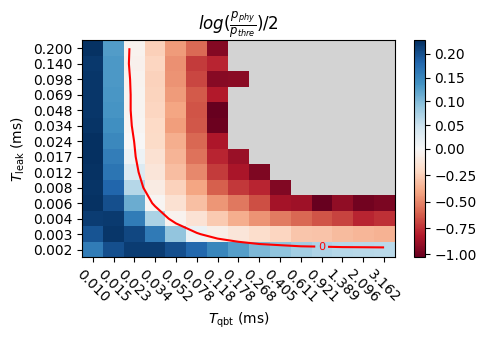

In [199]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize = (5,3.5))

plt.title(rf'$log(\frac{{p_{{phy}}}}{{p_{{thre}}}})/2$')
plt.xlabel(r'$T_\text{qbt}$ (ms)')
plt.ylabel(r'$T_\text{leak}$ (ms)')

temp_x = np.arange(len(qbt_lifetime_array))
temp_y = np.arange(len(decay_lifetime_array))
X, Y = np.meshgrid(temp_x, temp_y)

contour = plt.contour(X, Y, slope_array, levels=[0], colors='red')
plt.clabel(contour, inline=True, fontsize=8)


# cax = ax.imshow(slope_array, cmap= 'RdBu', norm= mcolors.TwoSlopeNorm(vmin = np.nanmin(slope_array),vcenter = 0,vmax = np.nanmax(slope_array)),
#         extent=[ qbt_lifetime_array[0], qbt_lifetime_array[-1],  decay_lifetime_array[0], decay_lifetime_array[-1]], aspect='auto',origin='lower')

cmap = plt.get_cmap('RdBu')
cmap = cmap(np.arange(cmap.N))
cmap[:, -1] = np.linspace(1, 1, cmap.shape[0])  # Set alpha to 1 for all colors
cmap = ListedColormap(cmap)
cmap.set_bad(color='lightgray')  # Set color for NaN values

cax = ax.imshow(slope_array, cmap= cmap, norm= mcolors.TwoSlopeNorm(vmin = np.nanmin(slope_array),vcenter = 0,vmax = np.nanmax(slope_array)),
        aspect='auto',origin='lower')
cbar = fig.colorbar(cax, ax=ax)
cbar.set_ticks([-1,-0.75,-0.5,-0.25,0,0.05,0.1,0.15,0.2])


ax.set_xticks(temp_x)
ax.set_yticks(temp_y)
ax.set_xticklabels([f'{val:.3f}' for val in qbt_lifetime_array], rotation = -45)
ax.set_yticklabels([f'{val:.3f}' for val in decay_lifetime_array])
# ax.set_xscale('log')
# ax.set_yscale('log')

plt.tight_layout()
fig.savefig('threshold.pdf')
